In [ ]:
# Run this block to suppress some warnings generated by certain out-of-date libraries
import warnings
warnings.filterwarnings("ignore", message="Passing unsupported keyword arguments to axis()")
warnings.filterwarnings("ignore", message="Using a string of single character colors as a color sequence is deprecated")

# Building a Binary Perceptron

This is my implementation of a linear classifier using a perceptron. It is largely compatible with sklearn library tools like GridSearchCV, Pipeline, etc.

I wrote methods for a HandFitLinearModel, which are then subclassed to create a BinaryPerceptron, which can handle classification tasks with 2 classes, and test it on a subset of the Iris set and the Sonar problem.

(As an extension, I show how to turn the Binary Perceptron into a multiclass model, which can handle classification tasks any number of classes, and test it on the full Iris set and the MNIST handwritten digits dataset)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

# Iris dataset prep

The first part of my implementation will use the Iris dataset. Below, I load it and do some exploratory data analysis (EDA).


In [ ]:
from sklearn.datasets import load_iris
dataset_iris = load_iris()
iris_df = pd.DataFrame(data=dataset_iris.data, columns = dataset_iris.feature_names).assign(species = dataset_iris.target_names[dataset_iris.target])
print("Iris Labels:", dataset_iris.target_names)
print("Iris Features:", dataset_iris.feature_names)
iris_df

Iris Labels: ['setosa' 'versicolor' 'virginica']
Iris Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
FEATURE_X = 'sepal length (cm)'
FEATURE_Y = 'sepal width (cm)'
LABEL_SUBSET = np.array(['setosa','versicolor'])
iris_df_subset = iris_df[[FEATURE_X, FEATURE_Y, 'species']][iris_df['species'].isin(LABEL_SUBSET)]

iris_df_subset

,sepal length (cm),sepal width (cm),species
0,5.1,3.5,setosa
1,4.9,3.0,setosa
2,4.7,3.2,setosa
3,4.6,3.1,setosa
4,5.0,3.6,setosa
...,...,...,...
95,5.7,3.0,versicolor
96,5.7,2.9,versicolor
97,6.2,2.9,versicolor
98,5.1,2.5,versicolor


In [ ]:
X = iris_df_subset.drop('species', axis=1).values
y = iris_df_subset['species'].values

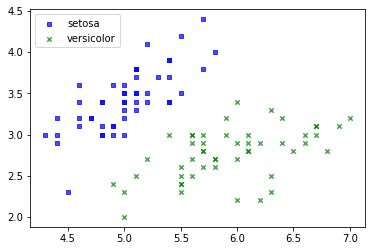

In [ ]:
from mlxtend.plotting import category_scatter
# Use panda dataframe
fig = category_scatter(x=FEATURE_X, y=FEATURE_Y, label_col='species',
                       data=iris_df_subset, legend_loc='upper left')

plt.show()

[]

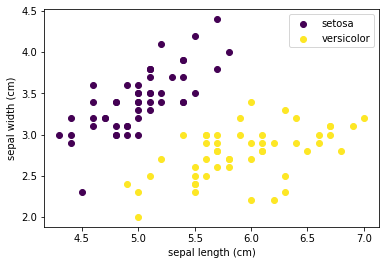

In [ ]:
from matplotlib import colors, cm
# A handy function to plot 2 feature classification datasets
def plot_2d_data(X, y, feature_X_label = "Feature 0", feature_Y_label = "Feature 1", cmap= 'viridis', **kwargs):

    # Convert labels to int encodings, based on the unique classes in the data.
    classes, indexes= np.unique(y, return_inverse=True)

    # Standardize coloring across all scatters; these are usually optional plotting parameters.
    cmap = cm.get_cmap(cmap, len(classes))
    color_norm = colors.Normalize()
    color_norm.autoscale(indexes)

    ax = plt.gca()
    for i, cls in enumerate(classes):
        ix = np.where(y == cls)
        # Plot the data points using the two features as x and y axis
        ax.scatter(X[ix,0], X[ix,1],color=cmap(color_norm(i)), label=cls,**kwargs)
    ax.legend()
    ax.set_xlabel(feature_X_label)
    ax.set_ylabel(feature_Y_label)

    return ax

# Sample usage:
plot_2d_data(X, y, feature_X_label = FEATURE_X, feature_Y_label = FEATURE_Y)
plt.plot()

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()

logreg_model.fit(X, y)
print("Accuracy on training data: {}:".format(logreg_model.score(X, y)))

Accuracy on training data: 1.0:


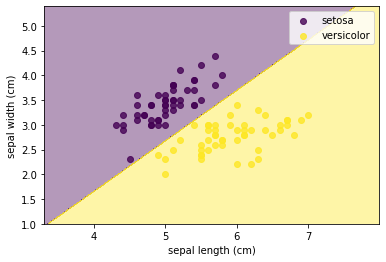

In [ ]:
from sklearn.preprocessing import LabelEncoder
from matplotlib import colors, cm
def plot_2d_decision_regions(X, y, clf, grid_interval = 0.005, feature_X_label = "Feature 0", feature_Y_label = "Feature 1", cmap = 'viridis', scatter_kwargs={}, contourf_kwargs={}):
    # Convert labels to int encodings, based on unique classes in the data
    encoder = LabelEncoder().fit(y)
    classes = encoder.classes_
    y_encoded = encoder.transform(y)

    # Standardize coloring across both scatter and contourf; these are usually optional plotting parameters.
    cmap = cm.get_cmap(cmap, len(classes))
    color_norm = colors.Normalize()
    color_norm.autoscale(y_encoded)

    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_interval),
                        np.arange(y_min, y_max, grid_interval))
    Z = encoder.transform(clf.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap = cmap,norm=color_norm,  **contourf_kwargs)

    #Plot scatter plot on top.
    ax = plt.gca()
    for i, cls in enumerate(classes):
        ix = np.where(y == cls)
        # Plot the data points using the two features as x and y axis
        ax.scatter(X[ix,0], X[ix,1],color=cmap(color_norm(i)), label=cls, alpha=0.8, **scatter_kwargs)

    # Adding custom legend for classes
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, classes)
    ax.set_xlabel(feature_X_label)
    ax.set_ylabel(feature_Y_label)


# Plotting decision regions of a fitted Logistic Regression model
logreg_model = LogisticRegression().fit(X, y)
plot_2d_decision_regions(X, y, clf=logreg_model, feature_X_label = FEATURE_X, feature_Y_label = FEATURE_Y)
plt.show()

In [ ]:
# Tranform y
classes, y_encoded = np.unique(y, return_inverse=True)
# classes should contain same labels as LABEL_SUBSET, though maybe differently ordered
# Note that y == classes[y_encoded]
print(classes)
print(y_encoded)

['setosa' 'versicolor']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
    from sklearn.preprocessing import LabelEncoder

    encoder = LabelEncoder().fit(y)
    classes = encoder.classes_
    # classes should contain same labels as LABEL_SUBSET, though maybe differently ordered
    y_encoded = encoder.transform(y)
    print(classes)
    print(y_encoded)

['setosa' 'versicolor']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


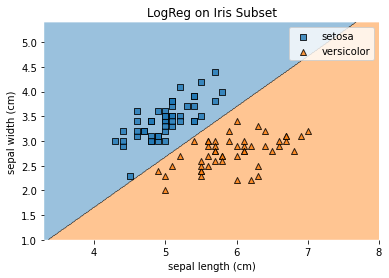

In [ ]:
from mlxtend.plotting import plot_decision_regions

#Retrain logreg_model with encoded labels to predict integers, not class names
encoded_logreg_model = LogisticRegression().fit(X, y_encoded)

# Plotting decision regions
ax = plot_decision_regions(X, y_encoded, clf=encoded_logreg_model)

# Adding custom legend for classes, since the class names are just ints
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, classes)

# Adding axes annotations
plt.xlabel(FEATURE_X)
plt.ylabel(FEATURE_Y)
plt.title('LogReg on Iris Subset')

plt.show()

# Linear model (Binary Perceptron)

In [ ]:
logreg_model = LogisticRegression()
logreg_model.fit(X, y)
print(logreg_model.coef_)
print(logreg_model.intercept_)
print(logreg_model.classes_)

[[ 3.0786959 -3.0220097]]
[-7.30634549]
['setosa' 'versicolor']


In [ ]:
unfitted_model = LogisticRegression()
print("Unfitted model has 'coef_' property?", hasattr(unfitted_model, 'coef_'))

Unfitted model has 'coef_' property? False


In [ ]:
class HandFitLinearModel():

    def fit(self, coef_init, intercept_init, classes):
        """
        Sets initial values for parameters.
        classes and coef_init can be passed in as any array-like, including lists and tuples.
        They are converted to np arrays before being saved as parameter properties.

        ** This is NOT the final version of fit for BinaryPerceptron! We will override this later **
        """
        if len(classes) != 2:
            raise ValueError("BinaryPerceptron only allows for 2 classes")
        # classes_: array of class labels (length 2)
        self.classes_ = np.array(classes)
        # coef_: array of weights (coefficients) for each feature
        self.coef_ = np.array(coef_init)
        # intercept_: the intercept or bias value
        self.intercept_ = intercept_init

        return self

In [ ]:
class HandFitLinearModel(HandFitLinearModel):

    """
    "Inherited" fit(), which sets up the parameters:
      classes_: array of class labels (length 2)
      coef_: array of weights (coefficients) for each feature
      intercept_: the intercept or bias value
    """

    def _decision_function_sample(self, sample_features):
        """Returns confidence score for sample.
        args:
          sample_features : array of feature values, length == len(self.coef_)

        returns:
          float : Confidence score for self.classes_[1] where >0 means this class would be predicted.
        """
        ### TODO ###
        return np.dot(sample_features, self.coef_) + self.intercept_


    def _predict_sample(self, sample_features):
        """
        args:
          sample_features: array of feature values, length == len(self.coef_)

        returns:
          predicted class label, either self.class_[0] or self.class_[1]
        """
        ### TODO ###
        val = self._decision_function_sample(sample_features)
        return self.classes_[1] if val > 0 else self.classes_[0]



In [ ]:
model = HandFitLinearModel()
model.fit(coef_init = [3.0786959, -3.0220097], intercept_init = -7.30634549, classes = np.unique(y))

# tweaking
#model.fit(coef_init = [2.8, -3], intercept_init = -7, classes = np.unique(y))

# See how our model performs on a few samples
print("%10s %12s %12s %12s %12s" % ("Sample #", "Features", "Label", "DecisionFunc", "Prediction"))
for i in range(0,len(X),10):
    print("%10d %12s %12s %12f %s" %(i, X[i], y[i], model._decision_function_sample(X[i]), model._predict_sample(X[i])))

  Sample #     Features        Label DecisionFunc   Prediction
         0    [5.1 3.5]       setosa    -2.182030 setosa
        10    [5.4 3.7]       setosa    -1.862824 setosa
        20    [5.4 3.4]       setosa    -0.956221 setosa
        30    [4.8 3.1]       setosa    -1.896835 setosa
        40    [5.  3.5]       setosa    -2.489900 setosa
        50    [7.  3.2]   versicolor     4.574095 versicolor
        60      [5. 2.]   versicolor     2.043115 versicolor
        70    [5.9 3.2]   versicolor     1.187529 versicolor
        80    [5.5 2.4]   versicolor     2.373659 versicolor
        90    [5.5 2.6]   versicolor     1.769257 versicolor


In [ ]:
from sklearn.base import ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

class HandFitLinearModel(HandFitLinearModel, ClassifierMixin):



    #def fit(X,y):
    #     """This is actually a dummy method. Ignore for now, but it needs to exist for check_is_fitted() to work"""
    #    pass

    def decision_function(self, X):
        """
        Predict confidence scores for samples.
        The confidence score for a sample is proportional to the signed
        distance of that sample to the hyperplane.
        Parameters
        ----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            Samples.
        Returns
        -------
        array, shape=(n_samples,)
            Confidence scores for self.classes_[1] where >0 means this
            class would be predicted.
        """
        check_is_fitted(self)
        check_array(X)
        n_features = len(self.coef_)
        if X.shape[1] != n_features:
            raise ValueError("X has %d features per sample; expecting %d" % (X.shape[1], n_features))

        ### TODO ###
        a = []
        for sample in X:
          a.append(self._decision_function_sample(sample))

        return np.asarray(a)

    def predict(self, X):
        """
        Predict class labels for samples in X.
        Parameters
        ----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            Samples.
        Returns
        -------
        C : array, shape [n_samples]
            Predicted class label (either self.classes_[0] or self.classes_[1]) per sample.
        """
        ### TODO ###
        a=[]
        for i in self.decision_function(X):
          a.append(self.classes_[1] if i > 0 else self.classes_[0])

        return np.asarray(a)
    '''
    Methods Inherited from ClassifierMixin:

    score(X, y[, sample_weight])
      Return the mean accuracy on the given test data and labels.
    '''


In [ ]:
# Fit by hand again!
model = HandFitLinearModel().fit(coef_init = [3.0786959, -3.0220097], intercept_init =  -7.30634549, classes = np.unique(y))

#model.fit(coef_init = [3.0786959, -3.0220097], intercept_init = -7.30634549, classes = np.unique(y))

confidence_scores = model.decision_function(X)
predictions = model.predict(X)

# See how our model performs on a few samples
print("%10s %12s %12s | %12s %12s" % ("Sample #", "Features", "Label", "DecisionFunc", "Prediction"))
for i in range(0,len(X),10):
      print("%10d %12s %12s %12f %s" %(i, X[i], y[i], confidence_scores[i], predictions[i]))


  Sample #     Features        Label | DecisionFunc   Prediction
         0    [5.1 3.5]       setosa    -2.182030 setosa
        10    [5.4 3.7]       setosa    -1.862824 setosa
        20    [5.4 3.4]       setosa    -0.956221 setosa
        30    [4.8 3.1]       setosa    -1.896835 setosa
        40    [5.  3.5]       setosa    -2.489900 setosa
        50    [7.  3.2]   versicolor     4.574095 versicolor
        60      [5. 2.]   versicolor     2.043115 versicolor
        70    [5.9 3.2]   versicolor     1.187529 versicolor
        80    [5.5 2.4]   versicolor     2.373659 versicolor
        90    [5.5 2.6]   versicolor     1.769257 versicolor


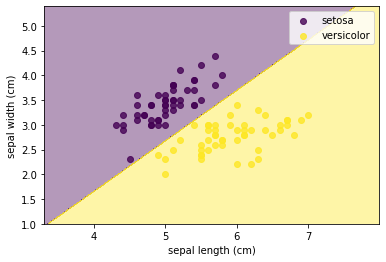

Overall Score: 1.0


In [ ]:
# Once again, lets try to tune the weights and biases ourselves...
model = HandFitLinearModel().fit(coef_init = [3.0786959, -3.0220097], intercept_init =  -7.30634549, classes = np.unique(y))

# tweaking
#model.fit(coef_init = [2.8, -3], intercept_init = -7, classes = np.unique(y))

plot_2d_decision_regions(X, y, clf=model, feature_X_label=FEATURE_X, feature_Y_label=FEATURE_Y)

plt.show()

print("Overall Score: {}".format(model.score(X,y)))

In [ ]:
class BinaryPerceptron(HandFitLinearModel):

    def _fit_sample(self, features, label_encoded, eta):
        """
        Precondition: self._coef and self._intercept have been initialized.

        Update the model's parameters with a single "update" for the given sample.

        args:
            features: 1D array of sample feature values (input)
            label: encoded class label (index of self.classes_)
            eta: float, learning rate
        """
        ### TODO ###
        prediction = self._predict_sample(features);

        if (prediction == self.classes_[label_encoded]):
          return

        elif label_encoded == 1:
          adjustments = np.multiply(features, eta)
          self.coef_ = np.add(self.coef_, adjustments)
          self.intercept_ += eta

        else:
          adjustments = np.multiply(features, eta)
          self.coef_ = np.subtract(self.coef_, adjustments)
          self.intercept_ -= eta

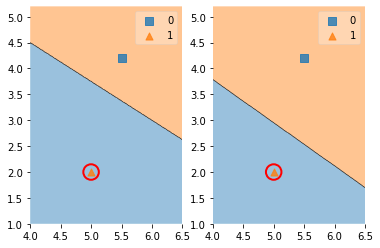

-------------
Training Data point 1: Features: [5. 2.] , Label: 1
-------------

Coefs before:    0.300,0.400	 Coefs after:    0.350,0.420
Intercept before:     -3.000	 Intercept after:     -2.990


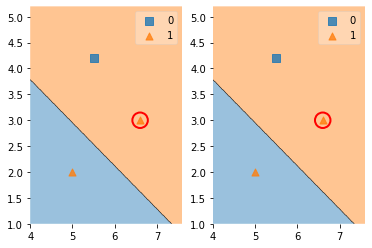

-------------
Training Data point 2: Features: [6.6 3. ] , Label: 1
-------------

Coefs before:    0.350,0.420	 Coefs after:    0.350,0.420
Intercept before:     -2.990	 Intercept after:     -2.990


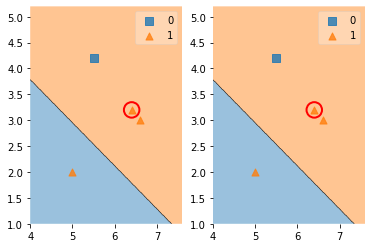

-------------
Training Data point 3: Features: [6.4 3.2] , Label: 1
-------------

Coefs before:    0.350,0.420	 Coefs after:    0.350,0.420
Intercept before:     -2.990	 Intercept after:     -2.990


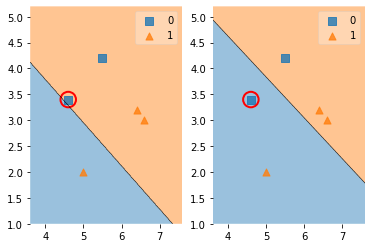

-------------
Training Data point 4: Features: [4.6 3.4] , Label: 0
-------------

Coefs before:    0.350,0.420	 Coefs after:    0.304,0.386
Intercept before:     -2.990	 Intercept after:     -3.000


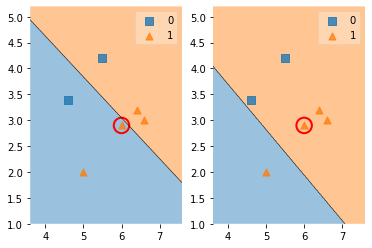

-------------
Training Data point 5: Features: [6.  2.9] , Label: 1
-------------

Coefs before:    0.304,0.386	 Coefs after:    0.364,0.415
Intercept before:     -3.000	 Intercept after:     -2.990


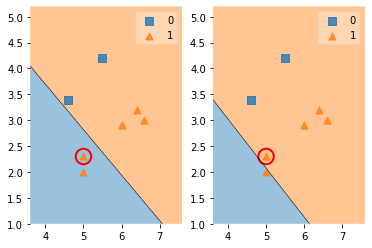

-------------
Training Data point 6: Features: [5.  2.3] , Label: 1
-------------

Coefs before:    0.364,0.415	 Coefs after:    0.414,0.438
Intercept before:     -2.990	 Intercept after:     -2.980


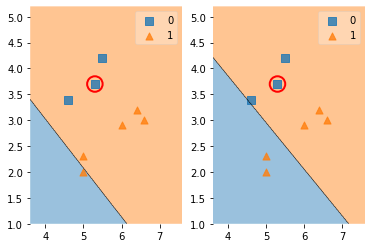

-------------
Training Data point 7: Features: [5.3 3.7] , Label: 0
-------------

Coefs before:    0.414,0.438	 Coefs after:    0.361,0.401
Intercept before:     -2.980	 Intercept after:     -2.990


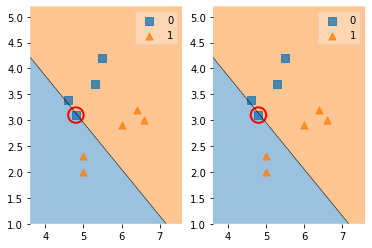

-------------
Training Data point 8: Features: [4.8 3.1] , Label: 0
-------------

Coefs before:    0.361,0.401	 Coefs after:    0.361,0.401
Intercept before:     -2.990	 Intercept after:     -2.990


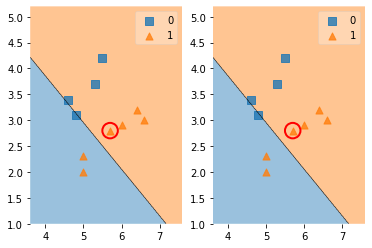

-------------
Training Data point 9: Features: [5.7 2.8] , Label: 1
-------------

Coefs before:    0.361,0.401	 Coefs after:    0.361,0.401
Intercept before:     -2.990	 Intercept after:     -2.990


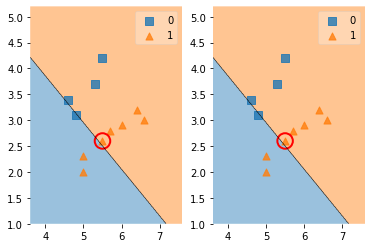

-------------
Training Data point 10: Features: [5.5 2.6] , Label: 1
-------------

Coefs before:    0.361,0.401	 Coefs after:    0.361,0.401
Intercept before:     -2.990	 Intercept after:     -2.990


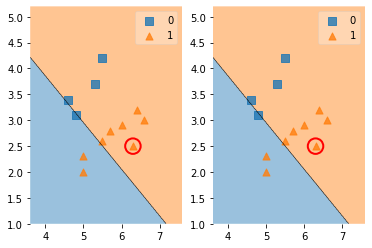

-------------
Training Data point 11: Features: [6.3 2.5] , Label: 1
-------------

Coefs before:    0.361,0.401	 Coefs after:    0.361,0.401
Intercept before:     -2.990	 Intercept after:     -2.990


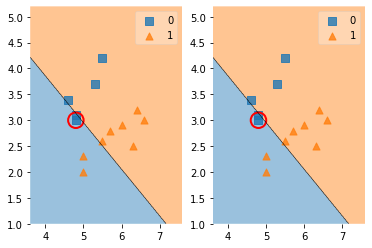

-------------
Training Data point 12: Features: [4.8 3. ] , Label: 0
-------------

Coefs before:    0.361,0.401	 Coefs after:    0.361,0.401
Intercept before:     -2.990	 Intercept after:     -2.990


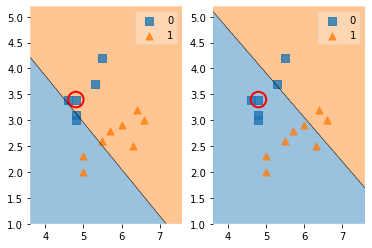

-------------
Training Data point 13: Features: [4.8 3.4] , Label: 0
-------------

Coefs before:    0.361,0.401	 Coefs after:    0.313,0.367
Intercept before:     -2.990	 Intercept after:     -3.000


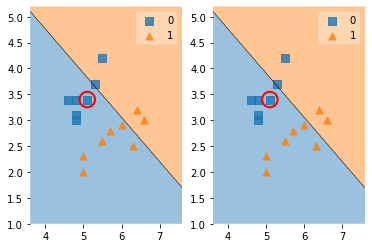

-------------
Training Data point 14: Features: [5.1 3.4] , Label: 0
-------------

Coefs before:    0.313,0.367	 Coefs after:    0.313,0.367
Intercept before:     -3.000	 Intercept after:     -3.000


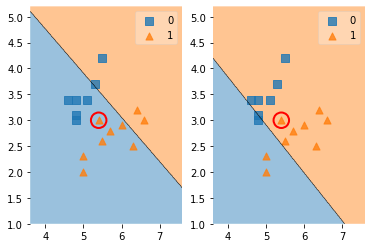

-------------
Training Data point 15: Features: [5.4 3. ] , Label: 1
-------------

Coefs before:    0.313,0.367	 Coefs after:    0.367,0.397
Intercept before:     -3.000	 Intercept after:     -2.990


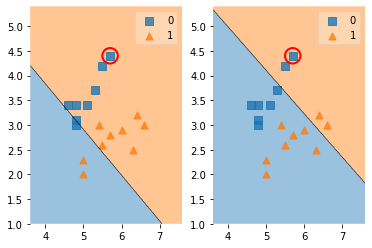

-------------
Training Data point 16: Features: [5.7 4.4] , Label: 0
-------------

Coefs before:    0.367,0.397	 Coefs after:    0.310,0.353
Intercept before:     -2.990	 Intercept after:     -3.000


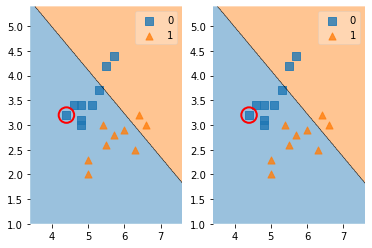

-------------
Training Data point 17: Features: [4.4 3.2] , Label: 0
-------------

Coefs before:    0.310,0.353	 Coefs after:    0.310,0.353
Intercept before:     -3.000	 Intercept after:     -3.000


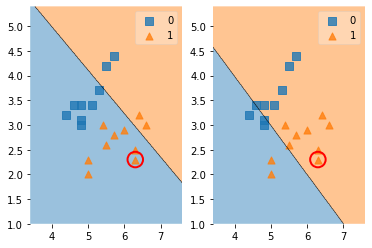

-------------
Training Data point 18: Features: [6.3 2.3] , Label: 1
-------------

Coefs before:    0.310,0.353	 Coefs after:    0.373,0.376
Intercept before:     -3.000	 Intercept after:     -2.990


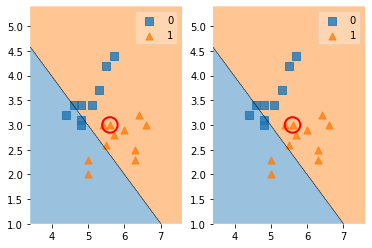

-------------
Training Data point 19: Features: [5.6 3. ] , Label: 1
-------------

Coefs before:    0.373,0.376	 Coefs after:    0.373,0.376
Intercept before:     -2.990	 Intercept after:     -2.990


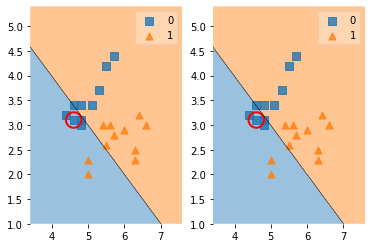

-------------
Training Data point 20: Features: [4.6 3.1] , Label: 0
-------------

Coefs before:    0.373,0.376	 Coefs after:    0.373,0.376
Intercept before:     -2.990	 Intercept after:     -2.990


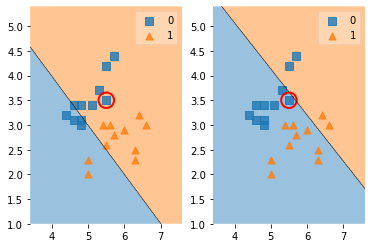

-------------
Training Data point 21: Features: [5.5 3.5] , Label: 0
-------------

Coefs before:    0.373,0.376	 Coefs after:    0.318,0.341
Intercept before:     -2.990	 Intercept after:     -3.000


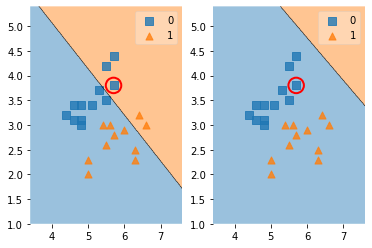

-------------
Training Data point 22: Features: [5.7 3.8] , Label: 0
-------------

Coefs before:    0.318,0.341	 Coefs after:    0.261,0.303
Intercept before:     -3.000	 Intercept after:     -3.010


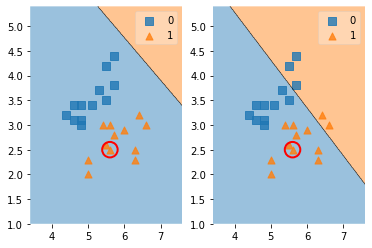

-------------
Training Data point 23: Features: [5.6 2.5] , Label: 1
-------------

Coefs before:    0.261,0.303	 Coefs after:    0.317,0.328
Intercept before:     -3.010	 Intercept after:     -3.000


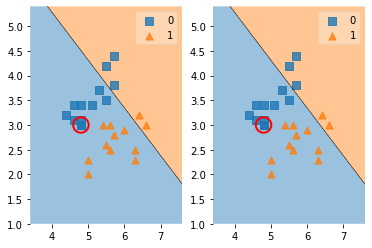

-------------
Training Data point 24: Features: [4.8 3. ] , Label: 0
-------------

Coefs before:    0.317,0.328	 Coefs after:    0.317,0.328
Intercept before:     -3.000	 Intercept after:     -3.000


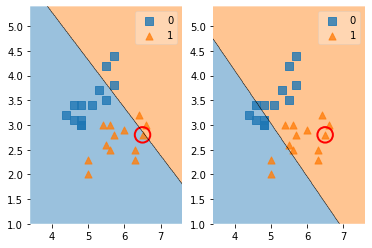

-------------
Training Data point 25: Features: [6.5 2.8] , Label: 1
-------------

Coefs before:    0.317,0.328	 Coefs after:    0.382,0.356
Intercept before:     -3.000	 Intercept after:     -2.990


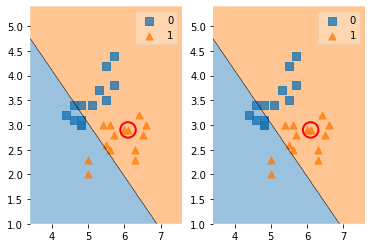

-------------
Training Data point 26: Features: [6.1 2.9] , Label: 1
-------------

Coefs before:    0.382,0.356	 Coefs after:    0.382,0.356
Intercept before:     -2.990	 Intercept after:     -2.990


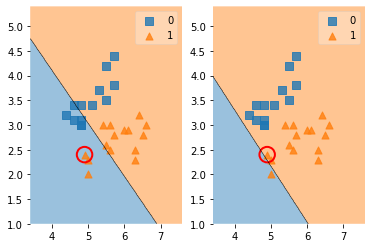

-------------
Training Data point 27: Features: [4.9 2.4] , Label: 1
-------------

Coefs before:    0.382,0.356	 Coefs after:    0.431,0.380
Intercept before:     -2.990	 Intercept after:     -2.980


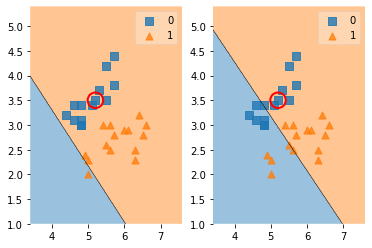

-------------
Training Data point 28: Features: [5.2 3.5] , Label: 0
-------------

Coefs before:    0.431,0.380	 Coefs after:    0.379,0.345
Intercept before:     -2.980	 Intercept after:     -2.990


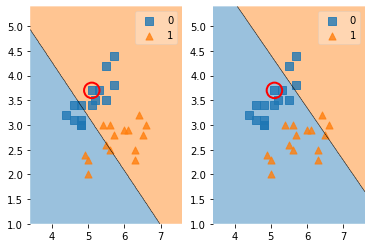

-------------
Training Data point 29: Features: [5.1 3.7] , Label: 0
-------------

Coefs before:    0.379,0.345	 Coefs after:    0.328,0.308
Intercept before:     -2.990	 Intercept after:     -3.000


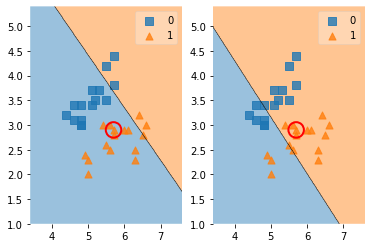

-------------
Training Data point 30: Features: [5.7 2.9] , Label: 1
-------------

Coefs before:    0.328,0.308	 Coefs after:    0.385,0.337
Intercept before:     -3.000	 Intercept after:     -2.990


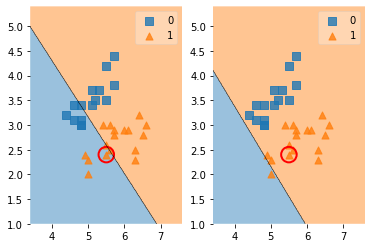

-------------
Training Data point 31: Features: [5.5 2.4] , Label: 1
-------------

Coefs before:    0.385,0.337	 Coefs after:    0.440,0.361
Intercept before:     -2.990	 Intercept after:     -2.980


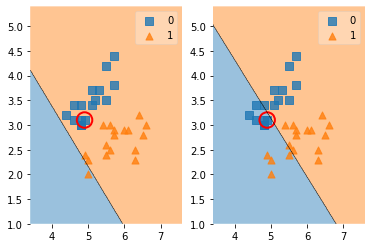

-------------
Training Data point 32: Features: [4.9 3.1] , Label: 0
-------------

Coefs before:    0.440,0.361	 Coefs after:    0.391,0.330
Intercept before:     -2.980	 Intercept after:     -2.990


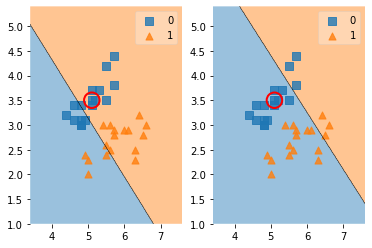

-------------
Training Data point 33: Features: [5.1 3.5] , Label: 0
-------------

Coefs before:    0.391,0.330	 Coefs after:    0.340,0.295
Intercept before:     -2.990	 Intercept after:     -3.000


In [ ]:
# Choose a randomly shuffled subset from the training data for visualization (shuffle(X[::3], y_encoded[::3], random_state=0))
from sklearn.utils import shuffle
X_subset, y_subset = shuffle(X[::3], y_encoded[::3], random_state=0)

#Start the model with some weights and bias. I've picked some values that make the line start near the data (coef_init = [.3, .4], intercept_init =  -3.0 , classes=[0,1]).
model = BinaryPerceptron()
model.fit(coef_init = [.3, .4], intercept_init =  -3.0 , classes=[0,1])

# Set a learning rate - I suggest 0.01
ETA = 0.01

# plot_decision_regions options
scatter_kwargs={'s':50, 'edgecolor': None}
scatter_highlight_kwargs = {'s': 240, 'edgecolor': 'red', 'linewidths': 2.0}

# Fit on each sample in the subset
# Note: The script skips fitting on the first element and just plots it to make plot_decision_regions happy. Just go with it.
for i in range(1, len(X_subset)):


    # make two subplots
    fig, axarr = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)


    # Plot decision boundaries (on left) and get model params BEFORE sample update
    plot_decision_regions(X_subset[:i+1], y_subset[:i+1], clf=model, X_highlight=X_subset[i:i+1,:],
                               scatter_kwargs=scatter_kwargs, scatter_highlight_kwargs = scatter_highlight_kwargs,
                               ax=axarr.flat[0])
    pre_coef_0, pre_coef_1, pre_intercept = model.coef_[0], model.coef_[1], model.intercept_


    # Do update on sample
    model._fit_sample(features=X_subset[i], label_encoded=y_subset[i], eta=ETA)


    # Plot decision boundaries (on right) and get model params AFTER sample update
    plot_decision_regions(X_subset[:i+1], y_subset[:i+1], clf=model, X_highlight=X_subset[i:i+1,:],
                               scatter_kwargs=scatter_kwargs, scatter_highlight_kwargs = scatter_highlight_kwargs,
                               ax=axarr.flat[1])
    post_coef_0, post_coef_1, post_intercept = model.coef_[0], model.coef_[1], model.intercept_

    plt.show()
    print("-------------\nTraining Data point {}: Features: {} , Label: {}\n-------------\n".format(i, X_subset[i], y_subset[i]))
    print("Coefs before:    {:5.3f},{:5.3f}\t Coefs after:    {:5.3f},{:5.3f}".format(pre_coef_0, pre_coef_1, post_coef_0, post_coef_1))
    print("Intercept before:{:11.3f}\t Intercept after:{:11.3f}".format(pre_intercept, post_intercept))

In [ ]:
class BinaryPerceptron(BinaryPerceptron):

    def _fit_epoch(self, X, y_encoded, eta):
        """
        Precondition: self._coef and self._intercept have been initialized.

        Perform one epoch of stochastic gradient descent on given samples.

        args:
            X : {array-like, sparse matrix}, shape (n_samples, n_features)
                Training data; 2d array of samples (rows), each column is a feature.
            y : ndarray of shape (n_samples,)
                Target values,  encoded class labels (index of self.classes_)
            eta: float, learning rate
        returns:
            1-d nd array of shape (n_samples,)
                Encoded label predictions (from each sample update)
        """
        rows = X.shape[0]
        for i in range(rows):
          self._fit_sample(X[i],y_encoded[i],eta)
        ### TODO ###
        pass


#### Testing/Visualizing _fit_epoch()




------------- Epoch Number 0 -------------



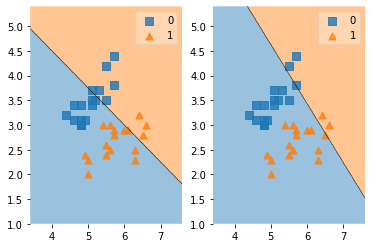

Coefs before:    0.300,0.400	 Coefs after:    0.338,0.283
Intercept before:     -3.000	 Intercept after:     -3.000
Training Score before: 0.412 	 Training Score after: 0.471 


------------- Epoch Number 1 -------------



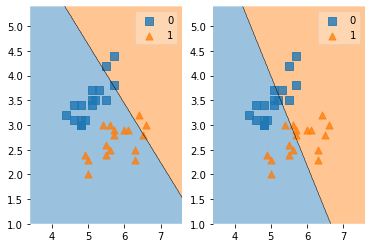

Coefs before:    0.338,0.283	 Coefs after:    0.415,0.229
Intercept before:     -3.000	 Intercept after:     -2.990
Training Score before: 0.471 	 Training Score after: 0.647 


------------- Epoch Number 2 -------------



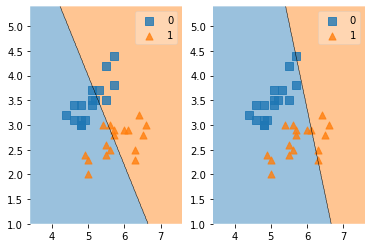

Coefs before:    0.415,0.229	 Coefs after:    0.430,0.123
Intercept before:     -2.990	 Intercept after:     -2.990
Training Score before: 0.647 	 Training Score after: 0.618 


------------- Epoch Number 3 -------------



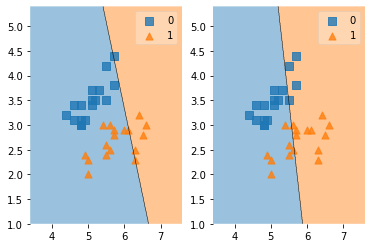

Coefs before:    0.430,0.123	 Coefs after:    0.494,0.076
Intercept before:     -2.990	 Intercept after:     -2.980
Training Score before: 0.618 	 Training Score after: 0.676 


------------- Epoch Number 4 -------------



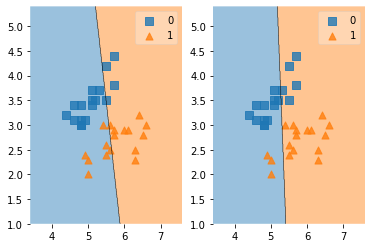

Coefs before:    0.494,0.076	 Coefs after:    0.543,0.029
Intercept before:     -2.980	 Intercept after:     -2.970
Training Score before: 0.676 	 Training Score after: 0.765 


------------- Epoch Number 5 -------------



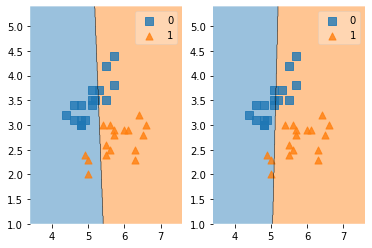

Coefs before:    0.543,0.029	 Coefs after:    0.590,-0.020
Intercept before:     -2.970	 Intercept after:     -2.960
Training Score before: 0.765 	 Training Score after: 0.735 


------------- Epoch Number 6 -------------



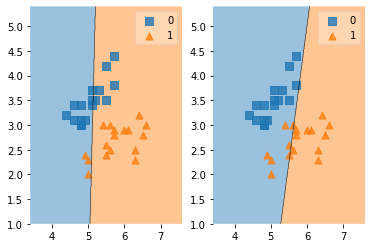

Coefs before:    0.590,-0.020	 Coefs after:    0.581,-0.105
Intercept before:     -2.960	 Intercept after:     -2.960
Training Score before: 0.735 	 Training Score after: 0.794 


------------- Epoch Number 7 -------------



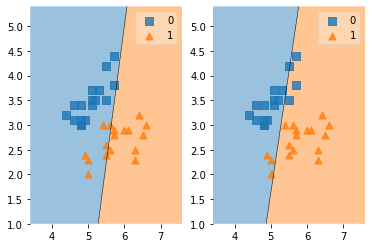

Coefs before:    0.581,-0.105	 Coefs after:    0.632,-0.129
Intercept before:     -2.960	 Intercept after:     -2.950
Training Score before: 0.794 	 Training Score after: 0.824 


------------- Epoch Number 8 -------------



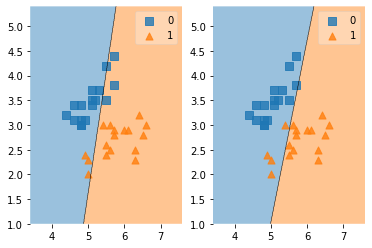

Coefs before:    0.632,-0.129	 Coefs after:    0.625,-0.170
Intercept before:     -2.950	 Intercept after:     -2.950
Training Score before: 0.824 	 Training Score after: 0.882 


------------- Epoch Number 9 -------------



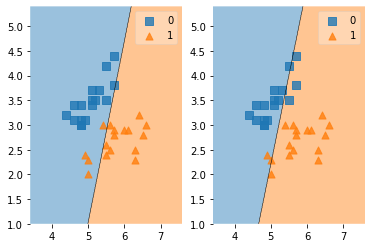

Coefs before:    0.625,-0.170	 Coefs after:    0.670,-0.186
Intercept before:     -2.950	 Intercept after:     -2.940
Training Score before: 0.882 	 Training Score after: 0.853 


------------- Epoch Number 10 -------------



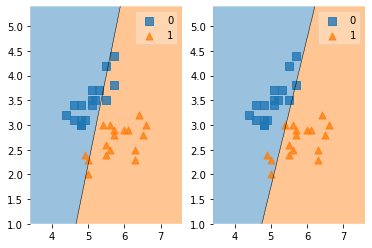

Coefs before:    0.670,-0.186	 Coefs after:    0.665,-0.221
Intercept before:     -2.940	 Intercept after:     -2.940
Training Score before: 0.853 	 Training Score after: 0.853 


------------- Epoch Number 11 -------------



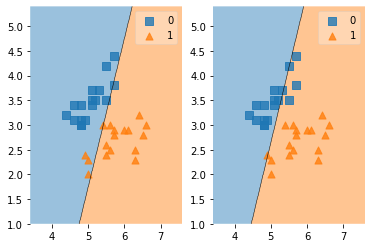

Coefs before:    0.665,-0.221	 Coefs after:    0.709,-0.233
Intercept before:     -2.940	 Intercept after:     -2.930
Training Score before: 0.853 	 Training Score after: 0.882 


------------- Epoch Number 12 -------------



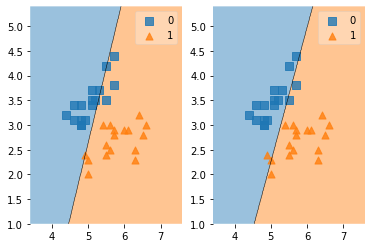

Coefs before:    0.709,-0.233	 Coefs after:    0.702,-0.258
Intercept before:     -2.930	 Intercept after:     -2.930
Training Score before: 0.882 	 Training Score after: 0.882 


------------- Epoch Number 13 -------------



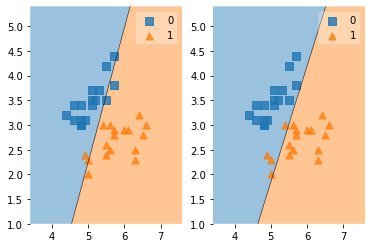

Coefs before:    0.702,-0.258	 Coefs after:    0.695,-0.296
Intercept before:     -2.930	 Intercept after:     -2.930
Training Score before: 0.882 	 Training Score after: 0.882 


------------- Epoch Number 14 -------------



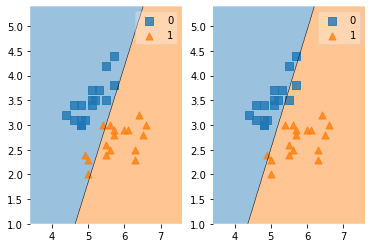

Coefs before:    0.695,-0.296	 Coefs after:    0.739,-0.308
Intercept before:     -2.930	 Intercept after:     -2.920
Training Score before: 0.882 	 Training Score after: 0.912 


------------- Epoch Number 15 -------------



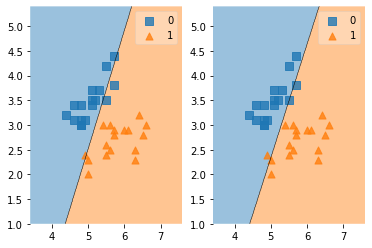

Coefs before:    0.739,-0.308	 Coefs after:    0.733,-0.319
Intercept before:     -2.920	 Intercept after:     -2.920
Training Score before: 0.912 	 Training Score after: 0.941 


------------- Epoch Number 16 -------------



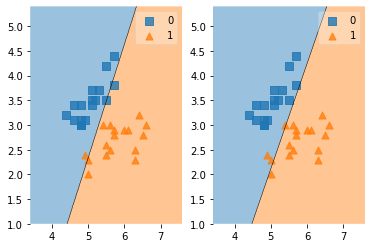

Coefs before:    0.733,-0.319	 Coefs after:    0.729,-0.343
Intercept before:     -2.920	 Intercept after:     -2.920
Training Score before: 0.941 	 Training Score after: 0.912 


------------- Epoch Number 17 -------------



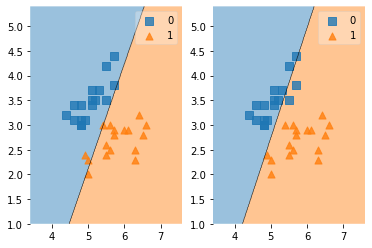

Coefs before:    0.729,-0.343	 Coefs after:    0.772,-0.347
Intercept before:     -2.920	 Intercept after:     -2.910
Training Score before: 0.912 	 Training Score after: 0.941 


------------- Epoch Number 18 -------------



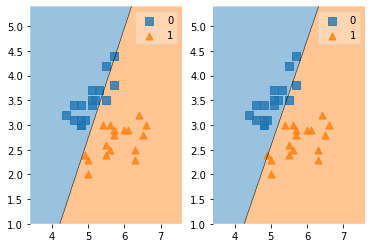

Coefs before:    0.772,-0.347	 Coefs after:    0.766,-0.358
Intercept before:     -2.910	 Intercept after:     -2.910
Training Score before: 0.941 	 Training Score after: 0.912 


------------- Epoch Number 19 -------------



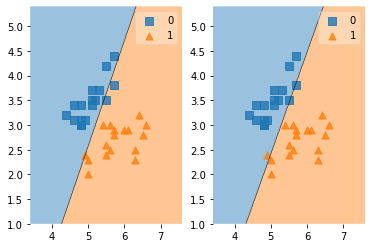

Coefs before:    0.766,-0.358	 Coefs after:    0.760,-0.369
Intercept before:     -2.910	 Intercept after:     -2.910
Training Score before: 0.912 	 Training Score after: 0.941 


------------- Epoch Number 20 -------------



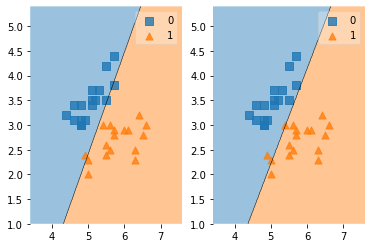

Coefs before:    0.760,-0.369	 Coefs after:    0.756,-0.393
Intercept before:     -2.910	 Intercept after:     -2.910
Training Score before: 0.941 	 Training Score after: 0.912 


------------- Epoch Number 21 -------------



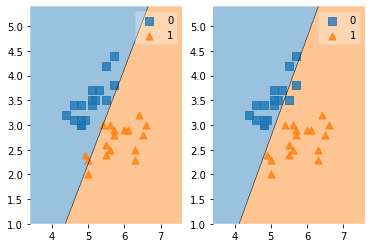

Coefs before:    0.756,-0.393	 Coefs after:    0.799,-0.397
Intercept before:     -2.910	 Intercept after:     -2.900
Training Score before: 0.912 	 Training Score after: 0.941 


------------- Epoch Number 22 -------------



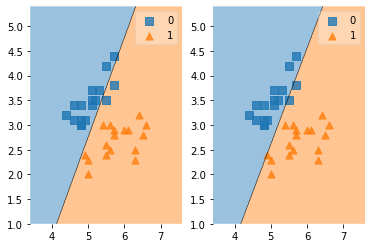

Coefs before:    0.799,-0.397	 Coefs after:    0.793,-0.408
Intercept before:     -2.900	 Intercept after:     -2.900
Training Score before: 0.941 	 Training Score after: 0.941 


------------- Epoch Number 23 -------------



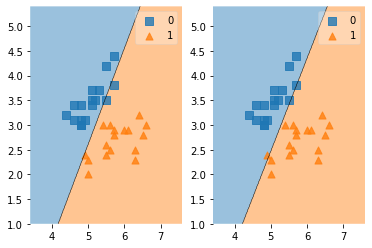

Coefs before:    0.793,-0.408	 Coefs after:    0.787,-0.419
Intercept before:     -2.900	 Intercept after:     -2.900
Training Score before: 0.941 	 Training Score after: 0.971 


------------- Epoch Number 24 -------------



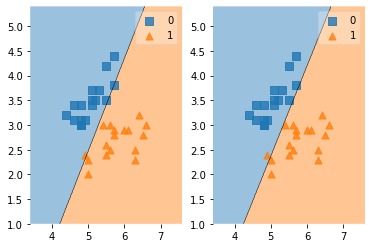

Coefs before:    0.787,-0.419	 Coefs after:    0.784,-0.430
Intercept before:     -2.900	 Intercept after:     -2.900
Training Score before: 0.971 	 Training Score after: 0.971 


------------- Epoch Number 25 -------------



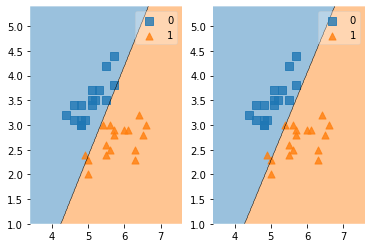

Coefs before:    0.784,-0.430	 Coefs after:    0.781,-0.441
Intercept before:     -2.900	 Intercept after:     -2.900
Training Score before: 0.971 	 Training Score after: 0.912 


------------- Epoch Number 26 -------------



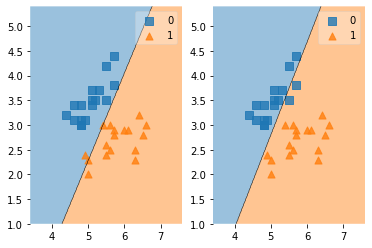

Coefs before:    0.781,-0.441	 Coefs after:    0.823,-0.438
Intercept before:     -2.900	 Intercept after:     -2.890
Training Score before: 0.912 	 Training Score after: 0.941 


------------- Epoch Number 27 -------------



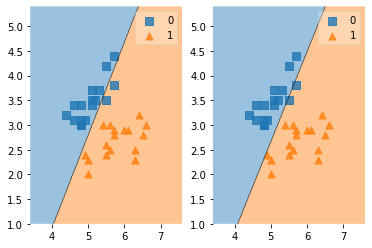

Coefs before:    0.823,-0.438	 Coefs after:    0.817,-0.449
Intercept before:     -2.890	 Intercept after:     -2.890
Training Score before: 0.941 	 Training Score after: 0.941 


------------- Epoch Number 28 -------------



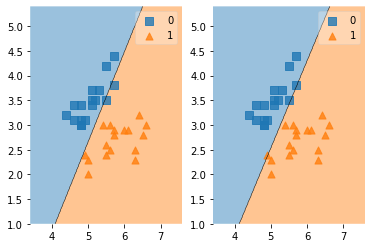

Coefs before:    0.817,-0.449	 Coefs after:    0.811,-0.460
Intercept before:     -2.890	 Intercept after:     -2.890
Training Score before: 0.941 	 Training Score after: 0.971 


------------- Epoch Number 29 -------------



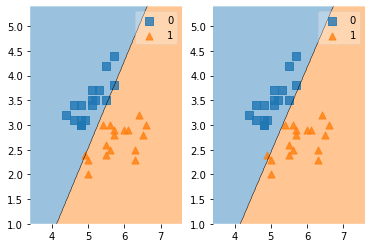

Coefs before:    0.811,-0.460	 Coefs after:    0.808,-0.471
Intercept before:     -2.890	 Intercept after:     -2.890
Training Score before: 0.971 	 Training Score after: 0.971 


------------- Epoch Number 30 -------------



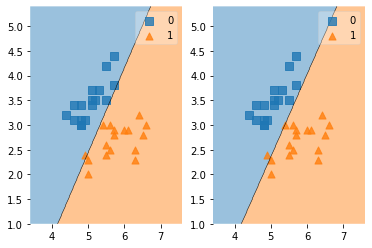

Coefs before:    0.808,-0.471	 Coefs after:    0.805,-0.482
Intercept before:     -2.890	 Intercept after:     -2.890
Training Score before: 0.971 	 Training Score after: 0.971 


------------- Epoch Number 31 -------------



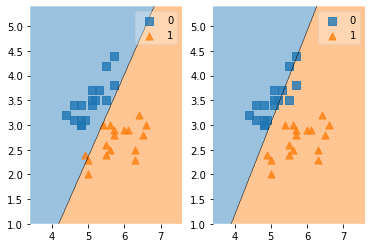

Coefs before:    0.805,-0.482	 Coefs after:    0.854,-0.458
Intercept before:     -2.890	 Intercept after:     -2.880
Training Score before: 0.971 	 Training Score after: 0.941 


------------- Epoch Number 32 -------------



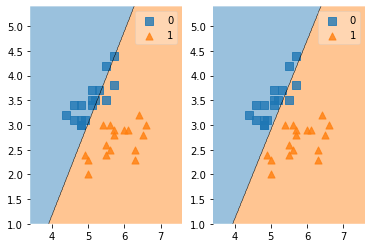

Coefs before:    0.854,-0.458	 Coefs after:    0.848,-0.469
Intercept before:     -2.880	 Intercept after:     -2.880
Training Score before: 0.941 	 Training Score after: 0.941 


------------- Epoch Number 33 -------------



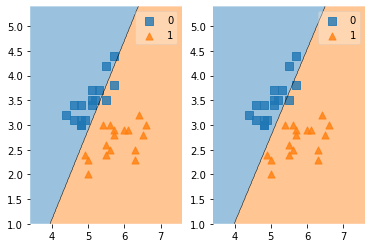

Coefs before:    0.848,-0.469	 Coefs after:    0.842,-0.480
Intercept before:     -2.880	 Intercept after:     -2.880
Training Score before: 0.941 	 Training Score after: 0.941 


------------- Epoch Number 34 -------------



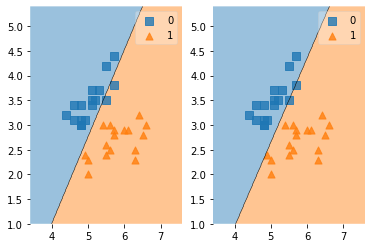

Coefs before:    0.842,-0.480	 Coefs after:    0.836,-0.491
Intercept before:     -2.880	 Intercept after:     -2.880
Training Score before: 0.941 	 Training Score after: 0.971 


In [ ]:
# Choose a randomly shuffled subset from the training data for visualization (shuffle(X[::3], y_encoded[::3], random_state=0))
from sklearn.utils import shuffle
X_subset, y_subset = shuffle(X[::3], y_encoded[::3], random_state=0)

#Start the model with some weights and bias. I've picked some values that make the line start near the data (coef_init = [.3, .4], intercept_init =  -3.0 , classes=[0,1]).
model = BinaryPerceptron()
model.fit(coef_init = [.3, .4], intercept_init =  -3.0 , classes=[0,1])

# Set a learning rate - I suggest 0.01
ETA = 0.01

# Choose number of epochs to run - I suggest 35
EPOCHS = 35

# Plot options
scatter_kwargs={'s':50, 'edgecolor': None}

for i in range(EPOCHS):

    fig, axarr = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

    # Plot decision boundaries (on left) and get model params BEFORE fitting the epoch
    plot_decision_regions(X_subset, y_subset, clf=model,
                               scatter_kwargs=scatter_kwargs,
                               ax=axarr.flat[0])

    pre_coef_0, pre_coef_1, pre_intercept = model.coef_[0], model.coef_[1], model.intercept_
    pre_score = model.score(X_subset,y_subset)


    # Fitting one epoch (pass) over the data
    model._fit_epoch(X_subset, y_subset, eta=ETA)


    # Plot decision boundaries (on right) and get model params AFTER fitting the epoch
    plot_decision_regions(X_subset, y_subset, clf=model,
                               scatter_kwargs=scatter_kwargs,
                               ax=axarr.flat[1])

    post_coef_0, post_coef_1, post_intercept = model.coef_[0], model.coef_[1], model.intercept_
    post_score = model.score(X_subset,y_subset)

    print("\n\n------------- Epoch Number {} -------------\n".format(i))
    plt.show()
    print("Coefs before:    {:5.3f},{:5.3f}\t Coefs after:    {:5.3f},{:5.3f}".format(pre_coef_0, pre_coef_1, post_coef_0, post_coef_1))
    print("Intercept before:{:11.3f}\t Intercept after:{:11.3f}".format(pre_intercept, post_intercept))
    print("Training Score before: {:5.3f} \t Training Score after: {:5.3f} ".format(pre_score, post_score))

    # Wait for user input to advance to the next Epoch


In [ ]:
from sklearn.base import BaseEstimator
import inspect
from sklearn.utils import check_random_state

class BinaryPerceptron(BinaryPerceptron, BaseEstimator):

    def __init__(self,
                  eta0 = 1.0, max_iter = 1000, #basic hyperparameters
                  verbose = 0,
                  shuffle = True, random_state=None, # shuffle hyperparameters
                  learning_rate = 'constant', power_t = 0.5,   # dynamic learning_rate hyperparameters
                  early_stopping = False,validation_fraction = 0.1, n_iter_no_change = 5, tol = 1e-3):   # params for early stopping

        """ Initializes BinaryPerceptron with given hyperparameters."""
        # Short cut for assigning all parameters as attributes with the same name
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)


    def _validate_params(self):
        """Validation of hyperparameters from __init__(); this is to be called from fit()."""
        # Validate Basic params
        if self.max_iter is not None and self.max_iter <= 0:
            raise ValueError("max_iter must be > zero. Got %f" % self.max_iter)
        if not isinstance(self.shuffle, bool):
            raise ValueError("shuffle parameter must be False")
        if self.eta0 <= 0.0:
            raise ValueError("eta0 must be > 0")
        # Convert int seed into a np.random.RandomState instance
        self.random_state = check_random_state(self.random_state)
        # parameters for dynamic learning rate
        if self.learning_rate not in ("constant", "invscaling"):
            raise ValueError("learning_rate parameter must be either 'constant', 'invscaling'")
        # parameters for early stopping
        if not isinstance(self.early_stopping, bool):
            raise ValueError("early_stopping parameter must be either True or False")
        if self.early_stopping:
            if self.n_iter_no_change < 1:
                raise ValueError("n_iter_no_change parameter must be >= 1")
            if not (0.0 < self.validation_fraction < 1.0):
                raise ValueError("validation_fraction parameter must be in range (0, 1)")

    '''
    Methods Inherited from BaseEstimator:

    get_params([deep])
      Get parameters for this estimator.
    set_params(**params)
      Set the parameters of this estimator.
    '''


In [ ]:
from sklearn.utils.validation import check_X_y

class BinaryPerceptron(BinaryPerceptron, BaseEstimator):

    def fit(self, X, y):
        """
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        New Attributes set up by fit: (All and only the public attributes set by fit have a trailing _)
        -------
        classes_ : ndarray of shape (n_classes,)
            The unique classes labels.
        coef_ : ndarray of shape (n_features,)
            Weights assigned to the features.
        intercept_ : ndarray of shape (1,)
            Constants in decision function.
        n_iter_ : int
            The actual number of iterations to reach the stopping criterion. For multiclass fits, it is the maximum over every binary fit.
        t_ : int
            Number of weight updates performed during training. Same as (n_iter_ * n_samples).
        """
        # Verify all parameters/properties from init
        self._validate_params()
        # Verify X and y are array-like; in our case, don't accept sparse scipy arrays
        X, y = check_X_y(X, y)
        # Don't assume y contains integer labels. Store array of unique class names in self.classes_,
        # This also returns a new y that contains indexes, rather than labels, in the range [0, n_classes).
        self.classes_, y = np.unique(y, return_inverse=True)
        # You can reconstruct the original y with self.classes_[y]


        ### TODO ###
        self.coef_ = np.zeros(len(X[0]))
        self.intercept_ = 0.0
        self.n_iter_ = 0
        self.t_ = 0

        predict_score = 0.0
        while predict_score < 1.0 and self.n_iter_ < self.max_iter:
          self._fit_epoch(X, y, self.eta0)

          self.n_iter_ += 1
          self.t_ = self.n_iter_ * len(X)
          predict_score = self.score(X, self.classes_[y])

          if self.verbose >= 1:
            print("...")
            print("-- Epoch %4d" % self.n_iter_)
            print("Norm: %3f, Bias: %8f, T: %4d, Train score: %8f" % (np.linalg.norm(X), self.intercept_, self.t_, predict_score))

            # if converged
            if predict_score >= 1.0:
              print("...")
              print("Convergence after %4d epochs" % self.n_iter_)

        # `fit` should always return `self`
        return self


...
-- Epoch    1
Norm: 63.379965, Bias: 1.000000, T:  100, Train score: 0.500000
...
-- Epoch    2
Norm: 63.379965, Bias: 0.000000, T:  200, Train score: 0.500000
...
-- Epoch    3
Norm: 63.379965, Bias: 0.000000, T:  300, Train score: 0.500000
...
-- Epoch    4
Norm: 63.379965, Bias: 0.000000, T:  400, Train score: 0.500000
...
-- Epoch    5
Norm: 63.379965, Bias: -1.000000, T:  500, Train score: 0.500000
...
-- Epoch    6
Norm: 63.379965, Bias: -1.000000, T:  600, Train score: 0.500000
...
-- Epoch    7
Norm: 63.379965, Bias: -1.000000, T:  700, Train score: 0.500000
...
-- Epoch    8
Norm: 63.379965, Bias: -1.000000, T:  800, Train score: 0.500000
...
-- Epoch    9
Norm: 63.379965, Bias: -2.000000, T:  900, Train score: 0.500000
...
-- Epoch   10
Norm: 63.379965, Bias: -2.000000, T: 1000, Train score: 0.500000
...
-- Epoch   11
Norm: 63.379965, Bias: -2.000000, T: 1100, Train score: 0.500000
...
-- Epoch   12
Norm: 63.379965, Bias: -2.000000, T: 1200, Train score: 0.500000
...
-- E

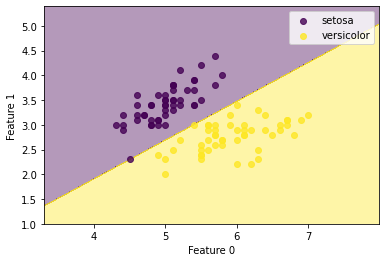

1.0
685


In [ ]:
#TODO
# Create BinaryPerceptron model; set hyperparameters like verbose, eta0, and max_iter.
model = BinaryPerceptron(verbose=1, eta0=1.0,max_iter=1000, random_state=42)
# Fit to X and y
model.fit(X,y)
# Plotting final decision regions
ax = plot_2d_decision_regions(X, y, clf=model, grid_interval = 0.005)
plt.show()

# Print the final training score and total iterations
print(model.score(X,y))
print(model.n_iter_)

In [ ]:
from sklearn.utils.validation import check_X_y
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

class BinaryPerceptron(BinaryPerceptron):

    #Override the old fit; incorporate all the hyperparameters.
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        New Attributes set up by fit: (All and only the public attributes set by fit have a trailing _)
        -------
        classes_ : ndarray of shape (n_classes,)
            The unique classes labels.
        coef_ : ndarray of shape (n_features,)
            Weights assigned to the features.
        intercept_ : ndarray of shape (1,)
            Constants in decision function.
        n_iter_ : int
            The actual number of iterations to reach the stopping criterion. For multiclass fits, it is the maximum over every binary fit.
        t_ : int
            Number of weight updates performed during training. Same as (n_iter_ * n_samples).
        """
        # Verify all parameters/properties from init
        self._validate_params()
        # Verify X and y are array-like; in our case, don't accept sparse scipy arrays
        X, y = check_X_y(X, y)
        # Don't assume y contains integer labels. Store array of unique class names in self.classes_,
        # This also returns a new y that contains indexes, rather than labels, in the range [0, n_classes).
        self.classes_, y = np.unique(y, return_inverse=True)
        # You can reconstruct the original y with self.classes_[y]

        ### TODO ###
        self.coef_ = np.zeros(len(X[0]))
        self.intercept_ = 0.0
        self.n_iter_ = 0
        self.t_ = 0
        predict_score_train = 0.0
        # Option 3 variables
        recent_scores = [0] * self.n_iter_no_change
        count = 0
        prev_predict_score_val = 0
        termination = False


        # Option 3
        if self.early_stopping:
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.validation_fraction, random_state = self.random_state)

        while self.n_iter_ < self.max_iter:
          # Option 1 and 3
          if self.shuffle and self.early_stopping:
            X_shuffle, y_shuffle = shuffle(X_train, y_train, random_state = self.random_state)
            self._fit_epoch(X_shuffle, y_shuffle, self.eta0)
          # Option 1 only
          elif self.shuffle:
            X_shuffle, y_shuffle = shuffle(X, y, random_state = self.random_state)
            self._fit_epoch(X_shuffle, y_shuffle, self.eta0)
          # Option 3 only
          elif self.early_stopping:
            self._fit_epoch(X_train, y_train, self.eta0)
          # Neither Option 1 nor 3
          else:
            self._fit_epoch(X, y, self.eta0)

          self.n_iter_ += 1
          self.t_ = self.n_iter_ * len(X)

          # Option 3
          if self.early_stopping:
            predict_score_val = self.score(X_test, self.classes_[y_test])
            if predict_score_val < (np.amax(recent_scores) + self.tol):
              count += 1
            else:
              count = 0
            # if performance regresses, reset count
            if predict_score_val < prev_predict_score_val:
              count = 0
            recent_scores.pop(0)
            recent_scores.append(predict_score_val)
            prev_predict_score_val = predict_score_val
            if count >= self.n_iter_no_change:
              termination = True


          predict_score_train = self.score(X, self.classes_[y])

          # Option 2
          if self.learning_rate == 'invscaling':
            self.eta0 = self.eta0 / pow(self.t_, self.power_t)

          # Verbosity
          if self.verbose >= 1:
            print("...")
            print("-- Epoch %4d" % self.n_iter_)
            print("Norm: %3f, Bias: %8f, T: %4d, Train score: %8f" % (np.linalg.norm(X), self.intercept_, self.t_, predict_score_train))
            # print("eta: %8f" % self.eta0)
            # Option 3
            if self.early_stopping:
              print("Validation score: %8f" % predict_score_val)
              if termination:
                print("Termination due to early stopping")

          # Option 3, termination
          if termination:
            return self

          # if converged; relevant only if early_stopping is false
          if not self.early_stopping and predict_score_train >= 1.0 and self.verbose >= 1:
            print("...")
            print("Convergence after %4d epochs" % self.n_iter_)
            return self

        # `fit` should always return `self`
        return self

...
-- Epoch    1
Norm: 63.379965, Bias: -2.000000, T:  100, Train score: 0.930000
Validation score: 0.900000
...
-- Epoch    2
Norm: 63.379965, Bias: -1.900000, T:  200, Train score: 0.990000
Validation score: 1.000000
...
-- Epoch    3
Norm: 63.379965, Bias: -1.907071, T:  300, Train score: 0.990000
Validation score: 1.000000
...
-- Epoch    4
Norm: 63.379965, Bias: -1.907479, T:  400, Train score: 0.990000
Validation score: 1.000000
...
-- Epoch    5
Norm: 63.379965, Bias: -1.907500, T:  500, Train score: 0.990000
Validation score: 1.000000
...
-- Epoch    6
Norm: 63.379965, Bias: -1.907501, T:  600, Train score: 0.990000
Validation score: 1.000000
...
-- Epoch    7
Norm: 63.379965, Bias: -1.907501, T:  700, Train score: 0.990000
Validation score: 1.000000
Termination due to early stopping


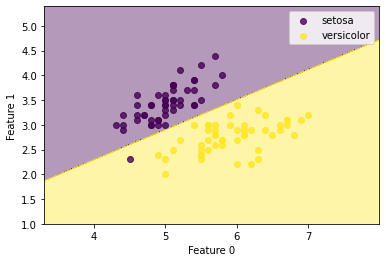

0.99
7


In [ ]:
#TODO
# Create BinaryPerceptron model; set hyperparameters like verbose, eta0,max_iter, shuffle, random_state, invscaling, early_stopping, etc.
model = BinaryPerceptron(verbose=1,eta0=1.0,max_iter=1000,shuffle=True, random_state=42, early_stopping = True, learning_rate='invscaling')
# Fit to X and y
model.fit(X,y)
# Plotting final decision regions
ax = plot_2d_decision_regions(X, y, clf=model, grid_interval = 0.005)
plt.show()

# Print the final training score and total iterations
print(model.score(X,y))
print(model.n_iter_)

...
-- Epoch    1
Norm: 71.508741, Bias: -1.000000, T:  100, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    2
Norm: 71.508741, Bias: -1.000000, T:  200, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    3
Norm: 71.508741, Bias: -1.000000, T:  300, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    4
Norm: 71.508741, Bias: -1.000000, T:  400, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    5
Norm: 71.508741, Bias: -1.000000, T:  500, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    6
Norm: 71.508741, Bias: -1.000000, T:  600, Train score: 1.000000
Validation score: 1.000000
Termination due to early stopping


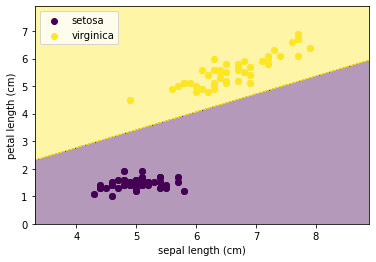

1.0
6


In [ ]:
# Try different subsets of the data.
# Subset 1
# Score 1.0 in 6 epochs
FEATURE_X_alt = 'sepal length (cm)'
FEATURE_Y_alt = 'petal length (cm)'
LABEL_SUBSET_alt = np.array(['setosa','virginica'])
iris_df_subset_alt = iris_df[[FEATURE_X_alt, FEATURE_Y_alt, 'species']][iris_df['species'].isin(LABEL_SUBSET_alt)]

X_alt = iris_df_subset_alt.drop('species', axis=1).values
y_alt = iris_df_subset_alt['species'].values

plot_2d_data(X_alt,y_alt)


"""
# Subset 2
# Score 0.91 in 7 epochs
FEATURE_X_alt = 'petal length (cm)'
FEATURE_Y_alt = 'petal width (cm)'
LABEL_SUBSET_alt = np.array(['versicolor','virginica'])
iris_df_subset_alt = iris_df[[FEATURE_X_alt, FEATURE_Y_alt, 'species']][iris_df['species'].isin(LABEL_SUBSET_alt)]

X_alt = iris_df_subset_alt.drop('species', axis=1).values
y_alt = iris_df_subset_alt['species'].values

plot_2d_data(X_alt,y_alt)
"""

"""
# Subset 3
# Score 0.71 in 9 epochs
FEATURE_X_alt = 'sepal length (cm)'
FEATURE_Y_alt = 'sepal width (cm)'
LABEL_SUBSET_alt = np.array(['versicolor','virginica'])
iris_df_subset_alt = iris_df[[FEATURE_X_alt, FEATURE_Y_alt, 'species']][iris_df['species'].isin(LABEL_SUBSET_alt)]

X_alt = iris_df_subset_alt.drop('species', axis=1).values
y_alt = iris_df_subset_alt['species'].values

plot_2d_data(X_alt,y_alt)
"""

# Train your BinaryPerceptron!
#TODO
model = BinaryPerceptron(verbose=1,eta0=1.0,max_iter=1000,shuffle=True, random_state=42, early_stopping = True, learning_rate='invscaling')
# Fit to X and y
model.fit(X_alt,y_alt)

#Plot!
plot_2d_decision_regions(X_alt, y_alt, clf=model, feature_X_label = FEATURE_X_alt, feature_Y_label = FEATURE_Y_alt)
plt.show()
print(model.score(X_alt,y_alt))
print(model.n_iter_)

In [ ]:
from sklearn.model_selection import cross_val_score
# Use ALL features of the data.
iris_df_subset_allfeat = iris_df[iris_df['species'].isin(LABEL_SUBSET)]
X_allfeat = iris_df_subset_allfeat.drop('species', axis=1).values
y_allfeat = iris_df_subset_allfeat['species'].values


# Create a BinaryPerceptron model, set hyperparameters!
model = BinaryPerceptron(verbose=1,eta0=1.0,max_iter=1000,shuffle=True, random_state=42, early_stopping = True, learning_rate='invscaling')
#Fit
model.fit(X_allfeat, y_allfeat);
# Use cross_val_score to do a 5-fold cross-validation
cv_scores = cross_val_score(model, X_allfeat, y_allfeat, cv=5)
print(cv_scores)

...
-- Epoch    1
Norm: 71.672659, Bias: -1.000000, T:  100, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    2
Norm: 71.672659, Bias: -1.000000, T:  200, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    3
Norm: 71.672659, Bias: -1.000000, T:  300, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    4
Norm: 71.672659, Bias: -1.000000, T:  400, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    5
Norm: 71.672659, Bias: -1.000000, T:  500, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    6
Norm: 71.672659, Bias: -1.000000, T:  600, Train score: 1.000000
Validation score: 1.000000
Termination due to early stopping
...
-- Epoch    1
Norm: 63.994140, Bias: -0.000000, T:   80, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    2
Norm: 63.994140, Bias: -0.000000, T:  160, Train score: 1.000000
Validation score: 1.000000
...
-- Epoch    3
Norm: 63.994140, Bias: -0.000000, T:  240, Train score: 1.000000
Val

In [ ]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create Dataframe
sonar_df = pd.read_csv('sonar.csv')

# Create X and y
X_sonar = sonar_df.drop('rock_mine', axis = 1).values
y_sonar = sonar_df['rock_mine'].values

In [ ]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sonar,y_sonar,test_size = .4, random_state = 42, stratify=y_sonar)


# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15) # contains 15 values between 10^-5 and 10^8.
param_grid = {'C': c_space, 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression: Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression: Validation Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression: Parameters: {'C': 1389495.494373136, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Logistic Regression: Validation Accuracy: 0.7340000000000001


In [ ]:
# Create the hyperparameter grid
max_iter_space = [10,100,1000]
eta0_space = [1.0,0.1,0.01,0.001,0.0001]
power_t_space = [.6,.5, .4, .3, .2]
n_iter_no_change_space = [5,10,25,50]

param_grid = {'max_iter': max_iter_space, 'eta0': eta0_space, 'power_t': power_t_space, 'n_iter_no_change': n_iter_no_change_space}

# Instantiate the logistic regression classifier: perceptron
perceptron = BinaryPerceptron()

# Instantiate the GridSearchCV object: perceptron_cv
perceptron_cv = GridSearchCV(perceptron,param_grid,cv=5)

# Fit it to the training data
perceptron_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Perceptron Parameters: {}".format(perceptron_cv.best_params_))
print("Tuned Perceptron Parameters: Validation Accuracy: {}".format(perceptron_cv.best_score_))


Tuned Perceptron Parameters: {'eta0': 0.0001, 'max_iter': 10, 'n_iter_no_change': 5, 'power_t': 0.5}
Tuned Perceptron Parameters: Validation Accuracy: 0.758


If you're anywhere in the ballpark of LogisticRegression's performance (you should be achieving within 5% of the same accuracy), congratulations! You have written a robust BinaryPerceptron class.

# Multiclass Perceptron (small extension)


In [ ]:
# Now use 2 features but ALL 3 labels
FEATURE_X_multi = 'petal length (cm)'
FEATURE_Y_multi = 'petal width (cm)'
iris_df_subset_multi = iris_df[[FEATURE_X_multi, FEATURE_Y_multi, 'species']]

X_multi = iris_df_subset_multi.drop('species', axis=1).values
y_multi = iris_df_subset_multi['species'].values

plot_2d_data(X_multi,y_multi)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
bp = BinaryPerceptron(random_state=42, learning_rate = 'invscaling', early_stopping=True)
clf = OneVsRestClassifier(bp).fit(X_multi, y_multi)
plot_2d_decision_regions(X_multi,y_multi,clf)
plt.show()
print(clf.score(X_multi,y_multi))

In [ ]:
from sklearn.metrics import confusion_matrix

# Use ALL the iris features, not just 2
X_all = iris_df.drop('species', axis=1).values
y_all = iris_df['species'].values

bp = BinaryPerceptron(random_state=42, learning_rate = 'invscaling', early_stopping=True)
clf = OneVsRestClassifier(bp).fit(X_all, y_all)
print(clf.score(X_all,y_all))
confusion_matrix(clf.predict(X_all), y_all)

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X_digits = digits.data
y_digits = digits.target

clf = OneVsRestClassifier(BinaryPerceptron(random_state=42, learning_rate = 'invscaling', early_stopping=True)).fit(X_digits, y_digits)

print(clf.score(X_digits,y_digits))

from sklearn.metrics import confusion_matrix
confusion_matrix(clf.predict(X_digits), y_digits)